# CCAI Data Processing

A notebook to clean up the Pol.is outputs for the Collective Constitutional AI experiments. This means cleaning out invalid participants and comments that weren't moderated in, and then recalculating the clusters.

In [2]:
import pandas as pd
import numpy as np
import csv

import seaborn as sns
import matplotlib.pyplot as plt
from textwrap import wrap
from sklearn.neighbors import kneighbors_graph
from sklearn.cluster import KMeans
import umap

from sklearn.decomposition import PCA

Get Pol.is export files with the results (`comments.csv`, `participants-votes.csv`).

Also get the `ids-to-toss.csv` which contains the IDs of participants who either put in more than 6 spammy comments (e.g. "The first time you have a chance at the top is the second one I just want you know I don't know if you're going on vacation but you know I" or "I'm going on my walk with the dogs now so I'll call when you get back to our office I"), *or* straighlined (only voted Agree or Disagree) *and* put in only spammy comments until that date. We will remove those participants.

In [3]:
path = "/Users/saffron/Documents/CIP/AA/cip.3akt5cdsfk.2023-07-18/"
comment_path = path + "comments.csv"
votes_path = path + "participants-votes.csv"
ids_to_toss_path = path + "ids-to-toss.csv"
comments_df = pd.read_csv(comment_path, index_col='comment-id')
votes_df = pd.read_csv(votes_path, index_col='participant')

comments_df.index = comments_df.index.astype(str)

- Remove participants who had low quality inputs or less than 25 votes (from `votes_df`)
- Only keep moderated-in comments (remove the rows from `comments_df`, remove the columns from `votes_df`)

In [4]:
with open(ids_to_toss_path, newline='\n') as f:
    reader = csv.reader(f)
    ids_to_toss = list(reader)

ids_to_toss = [int(item) for sublist in ids_to_toss for item in sublist]  # these are low quality inputs
print("initial number of participants: ", len(votes_df))
print("number of low quality IDs to toss: ", len(ids_to_toss))

initial number of participants:  1126
number of low quality IDs to toss:  37


In [5]:
# also toss the ones that have less than 25 votes
votes_df = votes_df[(votes_df['n-votes'] > 25) & (~votes_df.index.isin(ids_to_toss))]
print("final number of participants: ", len(votes_df))

final number of participants:  1002


In [6]:
plt.figure(figsize=(500, 500))
sns.set_context('poster')
sns.set_style('white')
sns.set(font_scale=.7)
sns.set_color_codes()

%matplotlib inline
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

<Figure size 50000x50000 with 0 Axes>

In [7]:
metadata_fields = ['xid', 'group-id', 'n-comments', 'n-votes', 'n-agree', 'n-disagree']
val_fields = [c for c in votes_df.columns.values if c not in metadata_fields]
# remove statements (columns) which were not moderated in (either inappropriate, or came in too late to be considered)
statements_all_in = sorted(list(comments_df.loc[comments_df["moderated"] > 0].index.array), key = int)

In [8]:
len(comments_df), len(statements_all_in)

(1418, 275)

In [9]:
metadata = votes_df[metadata_fields]
vals = votes_df[val_fields]
# If the participant didn't see the statement, it's a null value, here we fill in the nulls with zeros
vals = vals.fillna(0)  #<---in paper: column mean
vals = vals.sort_values("participant")
vals_all_in = vals[statements_all_in]

In [10]:
# drop columns from the vote matrix (val_fields) that aren't in 'statements_all_in'
moderated_out_comment_ids = [val for val in val_fields if val not in statements_all_in]
print(len(moderated_out_comment_ids))

1143


In [11]:
cleaned_comments_df = comments_df.loc[statements_all_in]
cleaned_votes_df = votes_df.drop(moderated_out_comment_ids, axis=1)

In [12]:
cleaned_comments_df

,timestamp,datetime,author-id,agrees,disagrees,moderated,comment-body
comment-id,,,,,,,
0,1688761206986,Fri Jul 07 13:20:06 PDT 2023,0,220,12,1,The AI should be as helpful to the user as pos...
1,1688761222055,Fri Jul 07 13:20:22 PDT 2023,0,292,50,1,The AI should be careful about balancing both ...
2,1688761225102,Fri Jul 07 13:20:25 PDT 2023,0,360,38,1,The AI should not say racist or sexist things.
3,1688761229303,Fri Jul 07 13:20:29 PDT 2023,0,249,14,1,The AI should not be threatening or aggressive.
4,1688761232887,Fri Jul 07 13:20:32 PDT 2023,0,244,10,1,The AI shouldn’t cause harm to the user or any...
...,...,...,...,...,...,...,...
901,1689261854099,Thu Jul 13 08:24:14 PDT 2023,0,67,1,1,The AI should be fair
902,1689262041364,Thu Jul 13 08:27:21 PDT 2023,729,27,21,1,AI should not be trained to be socially consci...
903,1689262122351,Thu Jul 13 08:28:42 PDT 2023,729,10,5,1,AI should not be trained with the principles o...


Now we have to recalculate the aggregate vote counts in cleaned_comments_df (the `agrees` and `disagrees` columns) because we dropped some participants.

In [13]:
# ensure the votes and comment columns/rows correspond to each other
print(set(cleaned_votes_df.columns) - set(metadata_fields) == set(cleaned_comments_df.index))
print(set(vals_all_in) == set(cleaned_comments_df.index))

True
True


In [14]:
# for every comment, recalculate the number of agree, disagree, pass votes according to the vote matrix
for comment in cleaned_comments_df.index:
    vc = cleaned_votes_df[comment].value_counts()
    if 0.0 in vc:
        cleaned_comments_df.loc[comment, 'passes'] = int(vc[0.0])
    else:
        cleaned_comments_df.loc[comment, 'passes'] = 0

    if 1.0 in vc:
        cleaned_comments_df.loc[comment, 'agrees'] = int(vc[1.0])
    else:
        cleaned_comments_df.loc[comment, 'agrees'] = 0

    if -1.0 in vc:
        cleaned_comments_df.loc[comment, 'disagrees'] = int(vc[-1.0])
    else:
        cleaned_comments_df.loc[comment, 'disagrees'] = 0

# Now our data is clean, and we can calculate stats!
The most important thing is to recalculate the opinion groups with the correct participants and vote counts. 

The below code is taken from the Polis [github](https://github.com/compdemocracy/analysis-python/blob/3ac43c259b64742c7ade46fc6278f88b2c09f094/notebooks/american-assembly-specific/american-assembly-representative-groups-and-comments.ipynb#L126) and is the standard way that PCA, opinion groups etc are calculated in the Pol.is report interface.


## Overall stats
How sparse is the dataset? How much agree, how much disagree, how much pass? Zero is 'passed' or 'did not see the comment to vote on it'. 1 is agree, -1 is disagree

In [15]:
melted = vals.melt();
all_votes = melted.count();
by_type = melted["value"].value_counts();
total_possible_votes = all_votes["value"];
total_agrees = by_type[1.0];
total_disagrees = by_type[-1.0];
total_without_vote = by_type[0.0];

print("Dimensions of matrix:", votes_df.shape)
print("Dimensions of matrix:", vals.shape)
print("Total number of possible votes:", total_possible_votes)
print("Total number of agrees:", total_agrees)
print("Total number of disagrees:", total_disagrees)
print("Total without vote:", total_without_vote)
print("Percent sparse: ", total_without_vote / total_possible_votes,"%")

Dimensions of matrix: (1002, 1424)
Dimensions of matrix: (1002, 1418)
Total number of possible votes: 1420836
Total number of agrees: 28231
Total number of disagrees: 4587
Total without vote: 1388018
Percent sparse:  0.9769023307404936 %


## Full participants * comments matrix
Some things to notice about the matrix: comments are submitted over time, so participants who do not return will only have voted on the statements which were avialable when they arrived.

Long horizontal lines: participants who do return show up as a horizontal line sticking out into otherwise blank areas

Blank vertical lines: most likely statements which were moderated out of the conversation.

<Axes: ylabel='participant'>

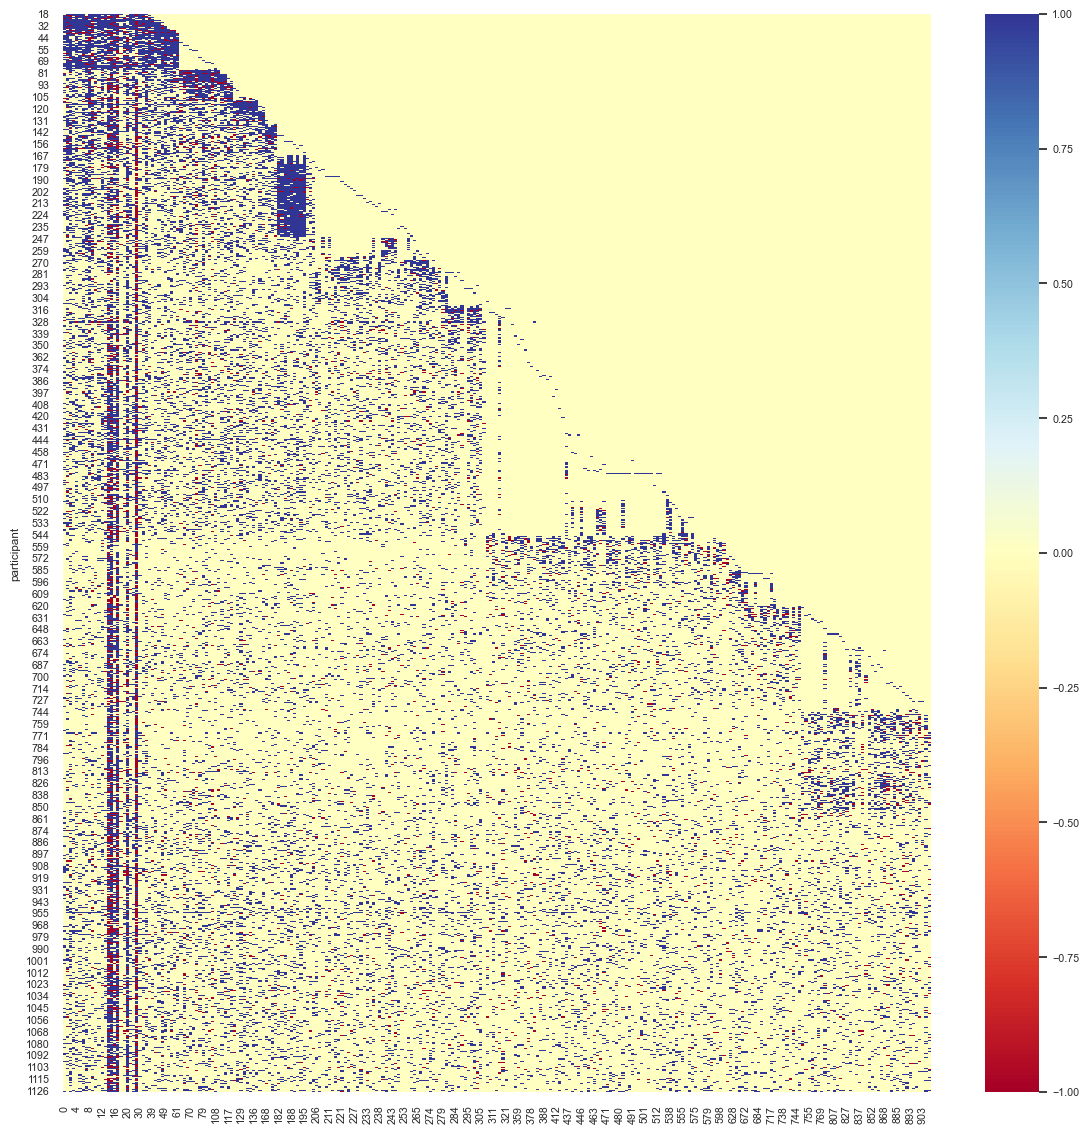

In [16]:
fig, ax = plt.subplots(figsize=(14,14))
sns.heatmap(vals_all_in, center=0, cmap="RdYlBu", ax=ax)

In [17]:
def polis_pca(dataframe, components):
    pca_object = PCA(n_components=components) ## pca is apparently different, it wants 
    pca_object = pca_object.fit(dataframe.T) ## .T transposes the matrix (flips it)
    coords = pca_object.components_.T ## isolate the coordinates and flip 
    explained_variance = pca_object.explained_variance_ratio_
    return coords, explained_variance

In [18]:
def c(comment, coords):
    fig, ax = plt.subplots(figsize=(7,5))
    plt.sca(ax)
    colorMap = {-1:'#A50026', 1:'#313695', 0:'#FEFEC050'}
    ax.scatter(
        x=coords[:,0],
        y=coords[:,1],
        c=vals[str(comment)].apply(lambda x: colorMap[x]),
        s=10
    )
    ax.set_title("\n".join(wrap(str(comment) + "  " + str(df_comments['comment-body'][comment]))), fontsize=14)
    print('Colorcode is based on how voted not clustering!')
    plt.show()

## Is the space explained by how much people vote?
In this chart, we take the PCA coordinates and color the participant locations by the number of total votes. Hopefully, it looks random. If it doesn't, we might imagine the following scenario:

1000 people vote, and there are very few controversial statements. They do not return.
1 person submits a statement which is incredibly controversial.
1000 more people vote, the space begins to take on structure, PCA is closely linked to vote count.
We know this scenario - that voters don't see controversial comments - happens. Polis mitigates in two ways:

polis eliminates participants who don't vote at least 7 times from the analysis
polis shows several highly controversial comments (large egeinvalue) in the first 10 comments participants see

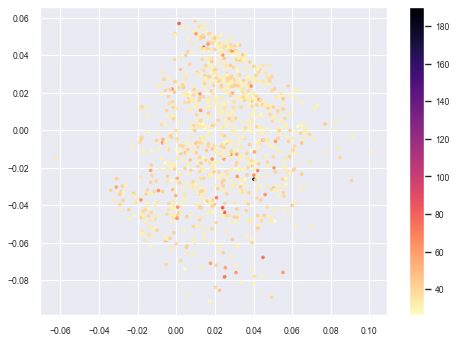

In [19]:
coords, embedding = polis_pca(vals_all_in, 2)

plt.figure(figsize=(7, 5), dpi=80)
plt.scatter(
    x=coords[:,0], 
    y=coords[:,1], 
    c=metadata['n-votes'],
    cmap="magma_r",
    s=5
)
plt.colorbar()

## Opinion groups
Now we have to recalculate the opinion groups with the correct participants and vote counts. 

This opinion group calculation code is taken from the Polis github and is the standard way it is calculated in the report. https://github.com/compdemocracy/analysis-python/blob/3ac43c259b64742c7ade46fc6278f88b2c09f094/notebooks/american-assembly-specific/american-assembly-representative-groups-and-comments.ipynb#L126

To form opinion groups, we take the PCA coordinates and perform K-means clustering with K=100. These fine-graine cluster serve as the basis for a more coarse-grained clustering, also using K-means.

*In fact, we take the 100 centers (obtained from the first K-means clustering), and run additional K-means clustering for K ranging between 2 and 5.* The K for which the silhoutte coefficient (a measure of withing-cluster similarity vs. between-cluster dissimilarity) is optimal is chosen for the opinion groups.

In [20]:
df = None

Explained variance: [0.07294794 0.0420472 ]


/Users/saffron/.pyenv/versions/3.10.2/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Plotting PCA embeddings with K-means, K=100
Optimal clusters for K= 2
Plotting PCA embeddings with K-means, K=2


/Users/saffron/.pyenv/versions/3.10.2/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/saffron/.pyenv/versions/3.10.2/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/saffron/.pyenv/versions/3.10.2/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/saffron/.pyenv/versions/3.10.2/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly t

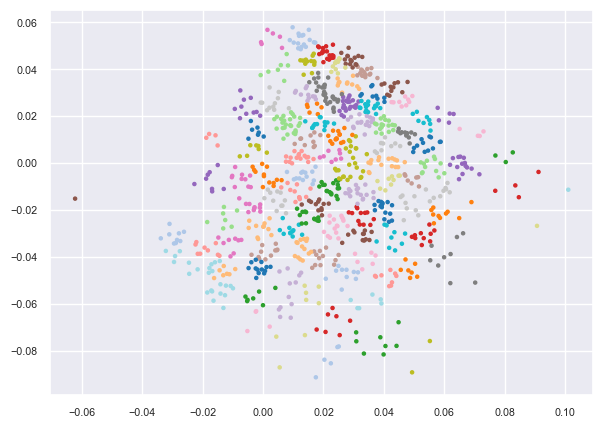

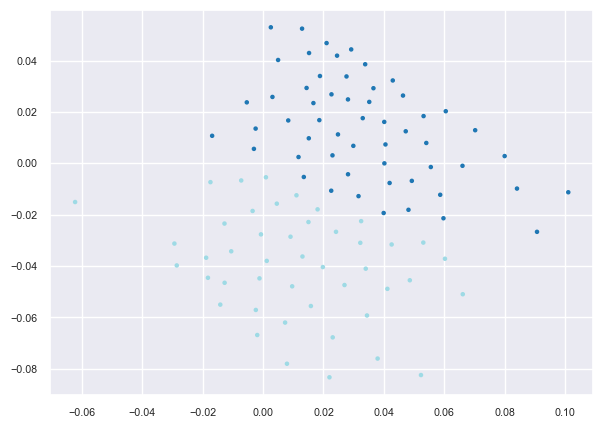

In [24]:
#given a dataframe, returns the found lables/clusters and the corresponding centers
def polis_kmeans_(dataframe, n_clusters=2):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(dataframe)
    
    return kmeans.labels_, kmeans.cluster_centers_
def plot_embedding_with_clusters(embedding_,labels_):
    print("Plotting PCA embeddings with K-means, K="+str(np.max(labels_)+1))
    fig, ax = plt.subplots(figsize=(7,5))
    plt.sca(ax)
    ax.scatter(
        x=embedding_[:,0],
        y=embedding_[:,1],
        c=labels_,
        cmap="tab20",
        s=5
    )
    #ax.set_title("", fontsize=14)
    
# Step 1 - get PCA clusters 
embedding, explained_variance = polis_pca(vals_all_in, 2)  
print("Explained variance:", explained_variance)

# Step 2 - K-means with K=100
clusters_100, centers = polis_kmeans_(embedding,n_clusters=100)
plot_embedding_with_clusters(embedding, clusters_100)

# Step 3 - find optimal K
from sklearn.metrics import silhouette_score 
silhoutte_star = -np.inf
for K in range(2,6):
    clusters_K, _ = polis_kmeans_(centers,n_clusters=K)
    silhouette_K = silhouette_score(centers, clusters_K)
    if silhouette_K >= silhoutte_star:
        K_star = K
        silhoutte_star = silhouette_K
        clusters_K_star = clusters_K
print('Optimal clusters for K=',str(K_star))
plot_embedding_with_clusters(centers,clusters_K_star)
 
# Step 4 - assign each voter to "optimal" cluster
clusters_star = np.zeros(len(clusters_100))
for k in range(100):#
    #find all indices with clusters k and assign them new star label
    clusters_star[np.where(clusters_100==k)]  = clusters_K_star[k]

In [25]:
len(votes_df), len(clusters_star)

(1002, 1002)

In [26]:
# these are all the people who are in cluster 0 -- move it to the consensus metric
print("Number of people in group 0 (aka group A): ", len(votes_df[clusters_star == 0]))
print("Number of people in group 1 (aka group B): ", len(votes_df[clusters_star == 1]))

Number of people in group 0 (aka group A):  619
Number of people in group 1 (aka group B):  383


In [28]:
cleaned_votes_df['group-id'] = [int(x) for x in clusters_star]

In [29]:
def calculate_group_aware_consensus(votes_df, comments_df):
    for cluster in votes_df['group-id'].value_counts().index:
        cluster_df = votes_df[votes_df['group-id'] == cluster]
        # sum across the rows for each column
        for comment in comments_df.index:
            value_counts = cluster_df[comment].value_counts()  # count the number of 1.0 (agree), -1.0 (disagree), and 0.0 (pass)
            if 1.0 not in value_counts:  # nobody has agreed
                proportion_agrees = 0.0
            proportion_agrees = value_counts[1.0]/value_counts.sum()
            comments_df.loc[comment, 'group_' + str(int(cluster)) + '_consensus'] = proportion_agrees
    return comments_df

In [30]:
cleaned_comments_df = calculate_group_aware_consensus(cleaned_votes_df, cleaned_comments_df)

In [31]:
cols_ordered = ['timestamp', 'datetime', 'author-id', 'agrees', 'disagrees', 'passes',
       'moderated', 'comment-body', 'group_0_consensus', 'group_1_consensus']

In [32]:
# rearrange the columns of cleaned_comments_df
cleaned_comments_df['passes'] = cleaned_comments_df['passes'].astype(int)
cleaned_comments_df = cleaned_comments_df[cols_ordered]

In [33]:
cleaned_comments_df.to_csv(path + 'clean_comments.csv')
cleaned_votes_df.to_csv(path + 'clean_votes.csv')

In [34]:
thresholds = np.linspace(0.6, 1.0, 20)
num_that_reach = []
for threshold in thresholds:
    num_that_reach.append(len(cleaned_comments_df[
    (cleaned_comments_df['group_0_consensus'] > threshold) &
    (cleaned_comments_df['group_1_consensus'] > threshold)
]))

Text(0, 0.5, 'number of statements that pass this threshold')

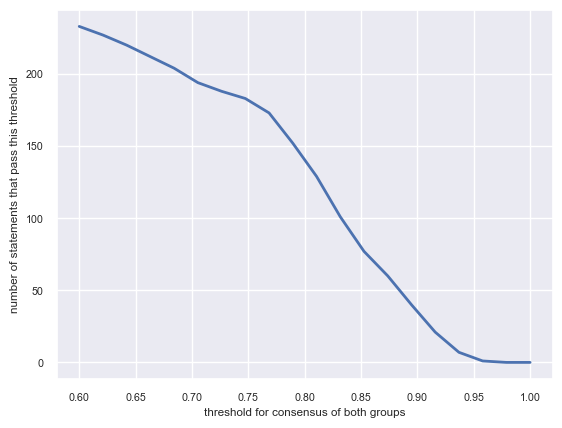

In [35]:
fig, ax = plt.subplots()

ax.plot(thresholds, num_that_reach, linewidth=2.0)
ax.set_xlabel("threshold for consensus of both groups")
ax.set_ylabel("number of statements that pass this threshold")